<a href="https://colab.research.google.com/github/Weimw/movielens-project/blob/main/cs224w_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation

In [2]:
%%capture
# Install torch geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
! git clone https://github.com/Weimw/movielens-project.git

In [16]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [4]:
%cd movielens-project

/content/movielens-project


Double check that our environment is working as expected.

In [6]:
torch_geometric.__version__

'2.2.0'

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

##1. MovieLens 100K without node features

### Dataset Preprocessing

In [8]:
col_names = ['user_id','item_id','rating','timestamp']
df = pd.read_csv("./data/ml_100k/u.data",sep = "\t", names = col_names)
df.drop('timestamp', axis = 1, inplace = True)
print('The whole dataset has {} entries'.format(len(df)))
display(df.head(5))

The whole dataset has 100000 entries


,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


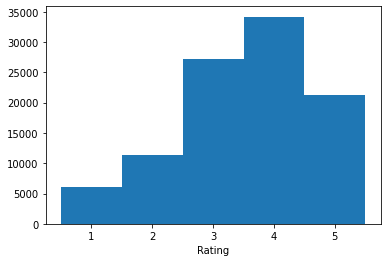

In [15]:
# plot the distribution of ratings
fig, ax = plt.subplots()
ax.hist(df['rating'], bins = np.arange(0,6) + 0.5)
ax.set_xlabel('Rating')
plt.show()

In [17]:
# Perform a train-test split based on interaction level
train, test = train_test_split(df.values, test_size = 0.2, random_state = 16)
train_df = pd.DataFrame(train, columns = df.columns)
test_df = pd.DataFrame(test, columns = df.columns)

In [18]:
print("Size of training set: ", len(train_df))
print("Size of test set: ", len(test_df))

Size of training set:  80000
Size of test set:  20000


Since the split is based on rating level, not all users and items are presenting in the training set. Thus, we will filter the test set to only include user, item appeared in the training set.

In [20]:
# Encode target labels with value between 0 and n_classes-1.
en_user = preprocessing.LabelEncoder()
en_item = preprocessing.LabelEncoder()
train_df['user_id_idx'] = en_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = en_item.fit_transform(train_df['item_id'].values)

train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

# filter test df
has_user = test_df['user_id'].isin(train_user_ids)
has_item = test_df['item_id'].isin(train_item_ids)
test_df = test_df[has_user & has_item]
print(len(test_df))

19958


In [21]:
test_df['user_id_idx'] = en_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = en_item.transform(test_df['item_id'].values)

In [24]:
# Get number of unique users and items
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print('There are {} unique users and {} unique items in the training set.'.format(n_users, n_items))

There are 943 unique users and 1645 unique items in the training set.


PyG represents graphs as sparse lists of node pairs. Since our graph is undirected, we need to include each edge twice, once for the edges from the users to the items and vice-versa.

Similar to above, we add `n_users` to the item tensor to ensure that every node in the graph has a unique identifier.

In [25]:
# Add edge index
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 523,  428,  504,  ..., 1128, 1164, 1242],
        [1356, 1034, 1114,  ...,  637,  837,   11]], device='cuda:0')

### Minibatch Sampling

### Model Architecture

The model we plan to use is GC-MC, which consists of a graph convolutional encoder model and a pairwise decoder model, to predict the entries in the adjacency matrix $M$. The encoder model $Z=f(X, A)$ takes as input a feature matrix $X$ for all the nodes in the bipartite graph, and a graph adjacency matrix $A$, produces a node embedding matrix $Z$. The decoder model operates on pairs of node embeddings $(z_{i},z_{j})$, where $z_{i}$ is for user embedding and $z_{j}$ is for movie embedding, and predict entries $M_{ij}$ in the output adjacency matrix $M$.


The model is then trained on minimizing the rooted mean square error between the predicting ratings in $M$ and the ground-truth labels.

## 2. MovieLens 1M with node features and LightGCN

### Dataset Creation